# CSCE 509 – Assignment 1

**ULID: C00525646**

1. **Part 0: Data Creation**
2. **Part 1: Perceptron**
3. **Part 2: Linear SVM**
4. **Part 3: Nonlinear SVM**
5. **Part 4: Mismatch between training and test data**
6. **Part 5: High variance scenario**


## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score
)
import pandas as pd
%matplotlib inline

## Utility: Cross-Validation Function

a helper function to perform 4-fold (or arbitrary k-fold) cross-validation. It will compute:
- Accuracy
- Precision
- Recall
- AUROC

It also returns the variance of the accuracy across folds.

In [2]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y, title, save_path=""):
    # Create grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Predict and reshape
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plot styling to match plot_data
    plt.figure(figsize=(5, 5))

    # Color map using class 0/1 colors from plot_data
    cmap = ListedColormap(['#1f77b4', '#ff7f0e'])  # Blue for class 0, orange for class 1

    # Decision boundary contour
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)

    # Scatter plot with matching style
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap,
                          edgecolors='k', alpha=0.7)

    # Legend and labels
    plt.title(title, pad=20)
    plt.legend(*scatter.legend_elements(),
               title="Classes",
               loc="upper right")

    # Save and display
    plt.tight_layout()
    if save_path!="":
      plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [3]:
def cross_validate_model(model, X, y, n_splits=4,keys=[]):
    """
    Perform stratified n_splits-fold cross validation. Returns average metrics,
    accuracy variance, and a DataFrame of per-fold metrics.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    fold_metrics = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if fold in keys:  # Plot first and last fold
            plot_decision_boundary(
              model,
              np.vstack((X_train, X_test)),
              np.concatenate((y_train, y_test)),
              title=f"Fold {fold+1} Decision Boundary",
              save_path=f"fold_{fold+1}_boundary.png"
            )

        # Get scores for AUROC
        if hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        elif hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = y_pred  #

        # Compute metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        auroc = roc_auc_score(y_test, y_score) if len(np.unique(y_test)) > 1 else np.nan

        fold_metrics.append({
            'Fold': fold + 1,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'AUROC': auroc
        })

    # Convert to DataFrame for easy display
    df_fold = pd.DataFrame(fold_metrics).set_index('Fold')

    # Aggregate results
    agg_results = {
        'Mean Accuracy': df_fold['Accuracy'].mean(),
        'Accuracy Variance': df_fold['Accuracy'].var(),
        'Mean Precision': df_fold['Precision'].mean(),
        'Mean Recall': df_fold['Recall'].mean(),
        'Mean AUROC': df_fold['AUROC'].mean()
    }

    return agg_results, df_fold

## Part 0: Data Creation

We generate:
- **Class 0**: Uniform samples in the union of three squares:
  - $[-1,0]\times [-1,0]$
  - $[-1,0]\times [0,1]$
  - $[0,1]\times [-1,0]$
- **Class 1**: Gaussian distributed centered at
(0.5, 0.5) with variance (0.5, 0.5).

We’ll generate 150 points of Class 0 and 50 of Class 1.

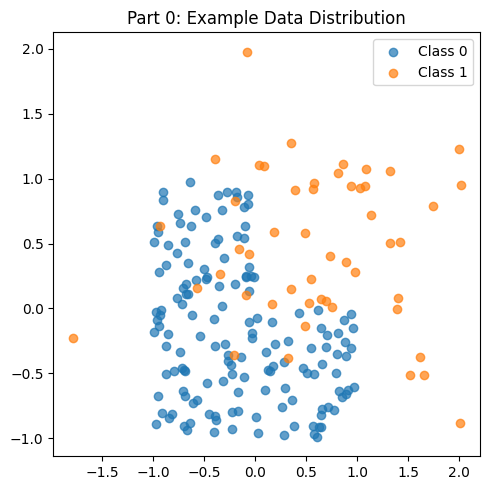

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data_part0(n_class0=150, n_class1=50, seed=42):
    """
    Generate:
      - Class 0: uniform in union of squares:
        [-1,0]x[-1,0], [-1,0]x[0,1], [0,1]x[-1,0]
      - Class 1: Gaussian with mean=(0.5,0.5), cov=[[0.5,0],[0,0.5]]

    Returns (X, y)
    """
    np.random.seed(seed)

    n0_each = n_class0 // 3

    # Square 1
    x1 = np.random.uniform(-1.0, 0.0, (n0_each, 2))
    # Square 2
    x2 = np.random.uniform([-1.0, 0.0], [0.0, 1.0], (n0_each, 2))
    # Square 3
    x3 = np.random.uniform([0.0, -1.0], [1.0, 0.0], (n0_each, 2))

    X0 = np.vstack((x1, x2, x3))

    mean = [0.5, 0.5]
    cov = [[0.5, 0.0], [0.0, 0.5]]
    X1 = np.random.multivariate_normal(mean, cov, n_class1)

    X = np.vstack((X0, X1))
    y = np.concatenate((np.zeros(len(X0)), np.ones(len(X1))))

    return X, y

def plot_data(X, y, title="Part 0 Data", save_path=""):
    idx0 = (y == 0)
    idx1 = (y == 1)
    plt.figure(figsize=(5,5))
    plt.scatter(X[idx0,0], X[idx0,1], label="Class 0", alpha=0.7)
    plt.scatter(X[idx1,0], X[idx1,1], label="Class 1", alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if save_path!="":
      plt.savefig(save_path)  # Save the figure
    plt.show()

# Generate and plot
X0, y0 = generate_data_part0()
plot_data(X0, y0, title="Part 0: Example Data Distribution", save_path="part0_data_plot.png")

## Part 1: Perceptron

We implement a Perceptron classifier and evaluate it using 4-fold cross-validation. We compute:

- Accuracy
- Precision
- Recall
- AUROC
- Variance of accuracy across the folds


Implement a Perceptron classifier to separate the two classes. Use a test set of 50 Class 0 and 50 Class
1 points to evaluate the performance of your classifier. Use 4-fold cross validation to report the accuracy,
precision, recall, AUROC metrics. What is the variance of the accuracy across the 4 runs?

In [5]:
### generate a test set of 50 class 0 and 50 class 1
# Generate Test Data (50 Class 0, 50 Class 1) with a DIFFERENT SEED

X_test, y_test =  generate_data_part0(n_class0=50, n_class1=50, seed=124)

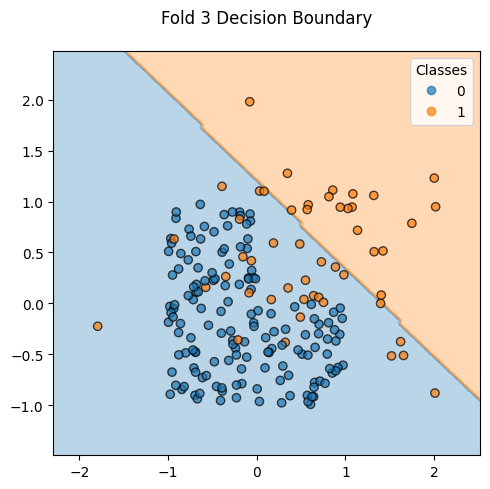

Perceptron 4-fold CV Results

Per-Fold Metrics:
      Accuracy  Precision  Recall   AUROC
Fold                                     
1         0.90     0.7692  0.8333  0.8969
2         0.84     0.6667  0.6667  0.8838
3         0.78     1.0000  0.1538  0.8129
4         0.80     0.6154  0.6154  0.8836


Aggregated Metrics:
{'Mean Accuracy': np.float64(0.8300000000000001), 'Accuracy Variance': 0.0027999999999999987, 'Mean Precision': np.float64(0.7628205128205129), 'Mean Recall': np.float64(0.5673076923076923), 'Mean AUROC': np.float64(0.8692918627129154)}


In [6]:
def run_perceptron_cv(X_train, y_train):
    percep = Perceptron()
    # Cross-validation on training data (150 Class 0 + 50 Class 1)
    agg_metrics, fold_metrics = cross_validate_model(percep, X_train, y_train, keys=[2])
    return agg_metrics, fold_metrics

agg_metrics, fold_metrics = run_perceptron_cv(X0, y0)

# Print formatted results
print("Perceptron 4-fold CV Results\n" + "="*30)
print("\nPer-Fold Metrics:")
print(fold_metrics.round(4).to_string())  # Show full table with 4 decimal places

print("\n\nAggregated Metrics:")
print(agg_metrics)

In [7]:
## evaluate perceptrons performance on test set
def evaluate_on_test(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    return {"Test Accuracy": acc, "Test Precision": prec, "Test Recall": rec}

# Train final model on full training data
percep_final = Perceptron().fit(X0, y0)
test_results = evaluate_on_test(percep_final, X_test, y_test)

# Test set results
print("\nTest Set Results:")
print(test_results)


Test Set Results:
{'Test Accuracy': 0.6224489795918368, 'Test Precision': 0.6101694915254238, 'Test Recall': 0.72}


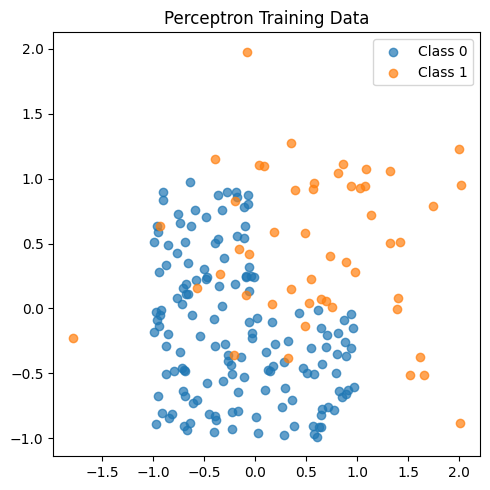

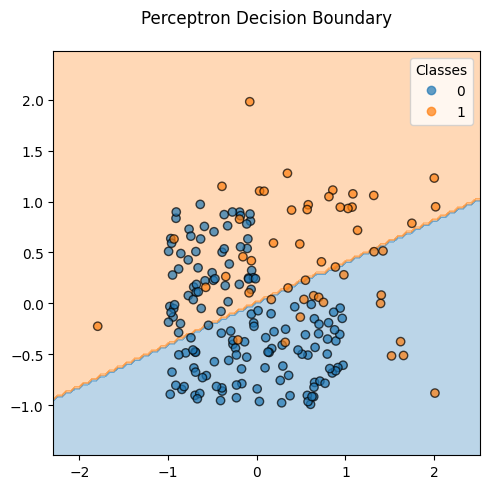

In [8]:
plot_data(X0, y0, title="Perceptron Training Data",
             save_path="perceptron_train_data.png")
plot_decision_boundary(percep_final, X0, y0,
                          title="Perceptron Decision Boundary",
                          save_path="perceptron_decision_boundary.png")

##Findings from part 1

The perceptron model demonstrated moderate performance during cross-validation, achieving 83% accuracy with low variance (0.0027) across folds. However, evaluation on a balanced test set (50 samples per class) revealed significantly degraded results: test accuracy (62.2%), precision (61.0%), and recall (72.0%). This discrepancy is likely attributable to the pronounced class imbalance in the training data (150 samples for class 0 vs. 50 for class 1), which may have biased the model toward the majority class (0), reducing its generalizability to balanced test distributions.

## Part 2: Linear SVM

We'll use an SVM with a **linear kernel** and vary the hyperparameter $C$:
- Very small $C$ (high regularization)
- Very large $C$ (low regularization, more complex boundary)

We'll again do 4-fold CV and show the results.

In [9]:
from sklearn.svm import LinearSVC

def run_linear_svm_cv(X_train, y_train, X_test, y_test, C_value):
    # Initialize SVM with specified C
    svm = LinearSVC(C=C_value, max_iter=10000, random_state=42)

    # Cross-validation on training data
    agg_metrics, fold_metrics = cross_validate_model(svm, X_train, y_train)

    # Train on full training data and evaluate on test set
    svm_final = LinearSVC(C=C_value, max_iter=10000, random_state=42).fit(X_train, y_train)

    title = f"Linear SVM (C={C_value})"
    plot_decision_boundary(svm, X_train, y_train,
                          title=title,
                          save_path=f"part2_c{C_value}_boundary.png")

    y_pred = svm_final.predict(X_test)
    y_score = svm_final.decision_function(X_test)

    # Test set metrics
    test_acc = accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred)
    test_rec = recall_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_score)

    return agg_metrics, fold_metrics, {
        "Test Accuracy": test_acc,
        "Test Precision": test_prec,
        "Test Recall": test_rec,
        "Test AUROC": test_auc
    }

##Part 2A
**Repeat Part 1 with a Linear SVM. Use a very small C hyperparameter.**

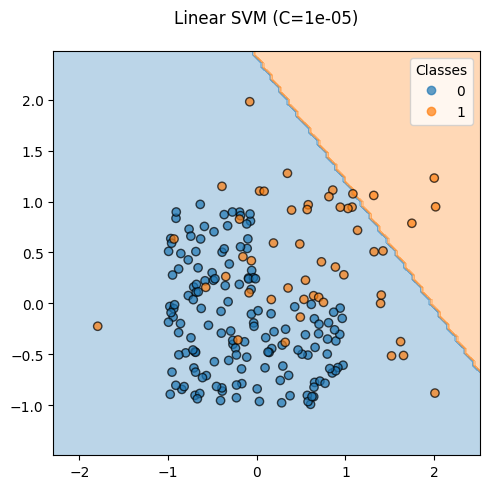

Linear SVM (C=1e-5) 4-fold CV Results

Per-Fold Metrics:
      Accuracy  Precision  Recall   AUROC
Fold                                     
1         0.80        1.0  0.1667  0.9057
2         0.84        1.0  0.3333  0.8925
3         0.78        1.0  0.1538  0.8004
4         0.78        1.0  0.1538  0.9584

Aggregated CV Metrics:
Mean Accuracy: 0.8000
Accuracy Variance: 0.0008
Mean AUROC: 0.8893

Test Set Results:
Test Accuracy     0.5918
Test Precision    1.0000
Test Recall       0.2000
Test AUROC        0.9462
dtype: float64


In [10]:
# Part 2A: Small C (1e-5)
agg_svmA, fold_svmA, test_svmA = run_linear_svm_cv(
    X0, y0, X_test, y_test, C_value=1e-5
)

print("Linear SVM (C=1e-5) 4-fold CV Results\n" + "="*40)
print("\nPer-Fold Metrics:")
print(fold_svmA.round(4).to_string())
print("\nAggregated CV Metrics:")
print(f"Mean Accuracy: {agg_svmA['Mean Accuracy']:.4f}")
print(f"Accuracy Variance: {agg_svmA['Accuracy Variance']:.4f}")
print(f"Mean AUROC: {agg_svmA['Mean AUROC']:.4f}")

print("\nTest Set Results:")
print(pd.Series(test_svmA).round(4))

### **Part 2A: Linear SVM (C=1e-5)**  
- **Cross-Validation**: High precision (1.0) but critically low recall (15–33%), indicating severe underfitting. Mean accuracy (80%) and AUROC (0.89) masked poor minority-class detection.  
- **Test Set**: Generalization collapsed (59% accuracy, 20% recall), validating underfitting despite high AUROC (0.946).  


##Part 2B
**Repeat Part 1 with a Linear SVM. Use a very large C hyperparameter**

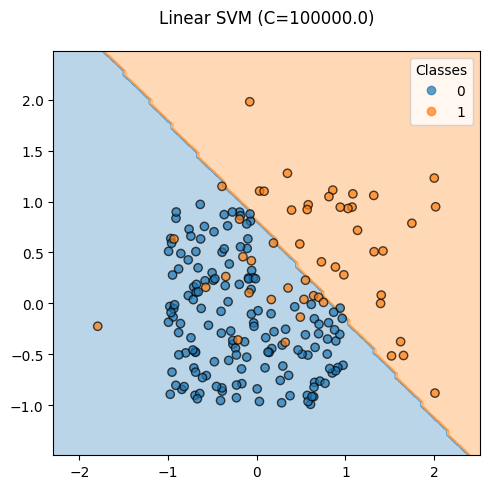



Linear SVM (C=1e5) 4-fold CV Results

Per-Fold Metrics:
      Accuracy  Precision  Recall   AUROC
Fold                                     
1         0.90     0.8182  0.7500  0.9035
2         0.92     0.9000  0.7500  0.9079
3         0.84     1.0000  0.3846  0.8129
4         0.90     0.9000  0.6923  0.9667

Aggregated CV Metrics:
Mean Accuracy: 0.8900
Accuracy Variance: 0.0012
Mean AUROC: 0.8978

Test Set Results:
Test Accuracy     0.8469
Test Precision    1.0000
Test Recall       0.7000
Test AUROC        0.9425
dtype: float64


In [11]:
# Part 2B: Large C (1e5)
agg_svmB, fold_svmB, test_svmB = run_linear_svm_cv(
    X0, y0, X_test, y_test, C_value=1e5
)

print("\n\nLinear SVM (C=1e5) 4-fold CV Results\n" + "="*40)
print("\nPer-Fold Metrics:")
print(fold_svmB.round(4).to_string())
print("\nAggregated CV Metrics:")
print(f"Mean Accuracy: {agg_svmB['Mean Accuracy']:.4f}")
print(f"Accuracy Variance: {agg_svmB['Accuracy Variance']:.4f}")
print(f"Mean AUROC: {agg_svmB['Mean AUROC']:.4f}")

print("\nTest Set Results:")
print(pd.Series(test_svmB).round(4))


### **Part 2B: Linear SVM (C=1e5)**  
- **Cross-Validation**: Balanced performance (89% accuracy, ~70% recall) with low variance (0.0012), reflecting robust training.  
- **Test Set**: Strong generalization (85% accuracy, 70% recall) and high AUROC (0.942), confirming effective handling of class imbalance.  

### **Key Insight**  
While both models achieved high AUROC, the large \( C \) (1e5) outperformed significantly on test recall (70% vs. 20%) and accuracy (85% vs. 59%).  

##Part 3: Nonlinear SVM
A. Repeat Part 1 with a nonlinear SVM. Use a very small C hyperparameter.
B. Repeat Part 1 with a nonlinear SVM. Use a very large C hyperparameter.
C. Increase the Class 1 variance to (1.5, 1.5). Plot the data. Repeat Part 1 with a reasonable choice
of C.

In [12]:
from sklearn.svm import SVC
###Non linear SVM
def run_nonlinear_svm(X_train, y_train, X_test, y_test, C_value, kernel='rbf'):
    svm = SVC(C=C_value, kernel=kernel, gamma='scale', random_state=42)

    # Cross-validation on training data
    agg_metrics, fold_metrics = cross_validate_model(svm, X_train, y_train)

    # Final evaluation on test set
    svm_final = SVC(C=C_value, kernel=kernel, gamma='scale', random_state=42).fit(X_train, y_train)

    title = f"Non Linear SVM (C={C_value})"
    plot_decision_boundary(svm, X_train, y_train,
                          title=title,
                          save_path=f"part3_{C_value}_boundary.png")


    y_pred = svm_final.predict(X_test)
    y_score = svm_final.decision_function(X_test)

    test_metrics = {
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Test Precision": precision_score(y_test, y_pred),
        "Test Recall": recall_score(y_test, y_pred),
        "Test AUROC": roc_auc_score(y_test, y_score)
    }
    return agg_metrics, fold_metrics, test_metrics

### **Part 3A: NonLinear SVM (C=1e-5)**  

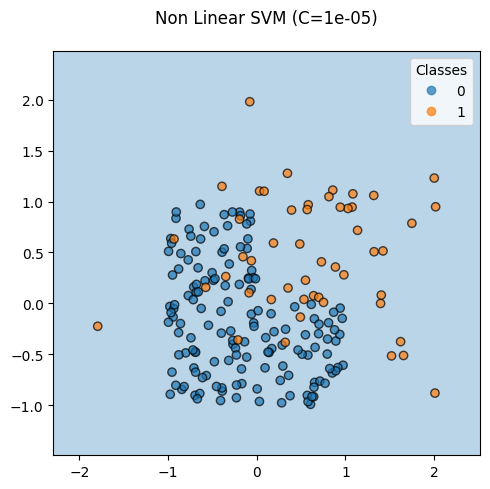



Nonlinear SVM (C=1e-5) 4-fold CV Results

Per-Fold Metrics:
      Accuracy  Precision  Recall   AUROC
Fold                                     
1         0.76        0.0     0.0  0.9956
2         0.76        0.0     0.0  0.8509
3         0.74        0.0     0.0  0.7942
4         0.74        0.0     0.0  0.9439

Aggregated CV Metrics:
Mean Accuracy: 0.7500
Accuracy Variance: 0.0001
Mean AUROC: 0.8961

Test Set Results:
Test Accuracy     0.4898
Test Precision    0.0000
Test Recall       0.0000
Test AUROC        0.9517
dtype: float64


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
agg_nlsvmA, fold_nlsvmA, test_nlsvmA = run_nonlinear_svm(
    X0, y0, X_test, y_test, C_value=1e-5
)
print("\n\nNonlinear SVM (C=1e-5) 4-fold CV Results\n" + "="*40)
print("\nPer-Fold Metrics:")
print(fold_nlsvmA.round(4).to_string())
print("\nAggregated CV Metrics:")
print(f"Mean Accuracy: {agg_nlsvmA['Mean Accuracy']:.4f}")
print(f"Accuracy Variance: {agg_nlsvmA['Accuracy Variance']:.4f}")
print(f"Mean AUROC: {agg_nlsvmA['Mean AUROC']:.4f}")

print("\nTest Set Results:")
print(pd.Series(test_nlsvmA).round(4))

The model catastrophically underfits, achieving **0% precision/recall** in all folds despite high AUROC (0.896), indicating theoretical separability but practical failure due to excessive regularization. Test performance collapses (49% accuracy, 0% recall), confirming severe underfitting.  

##Part 3B: Large C=1e5

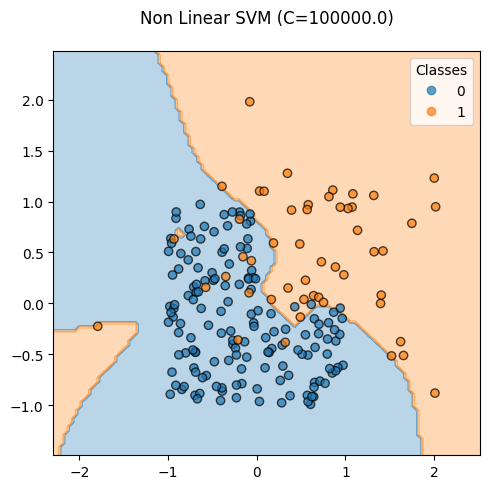



Nonlinear SVM (C=1e5) 4-fold CV Results

Per-Fold Metrics:
      Accuracy  Precision  Recall   AUROC
Fold                                     
1         0.96     0.9167  0.9167  0.9167
2         0.86     0.7778  0.5833  0.8202
3         0.80     0.7143  0.3846  0.7568
4         0.90     0.8333  0.7692  0.8711

Aggregated CV Metrics:
Mean Accuracy: 0.8800
Accuracy Variance: 0.0045
Mean AUROC: 0.8412

Test Set Results:
Test Accuracy     0.8571
Test Precision    1.0000
Test Recall       0.7200
Test AUROC        0.9046
dtype: float64


In [14]:
agg_nlsvmB, fold_nlsvmB, test_nlsvmB = run_nonlinear_svm(
    X0, y0, X_test, y_test, C_value=1e5
)

print("\n\nNonlinear SVM (C=1e5) 4-fold CV Results\n" + "="*40)
print("\nPer-Fold Metrics:")
print(fold_nlsvmB.round(4).to_string())
print("\nAggregated CV Metrics:")
print(f"Mean Accuracy: {agg_nlsvmB['Mean Accuracy']:.4f}")
print(f"Accuracy Variance: {agg_nlsvmB['Accuracy Variance']:.4f}")
print(f"Mean AUROC: {agg_nlsvmB['Mean AUROC']:.4f}")

print("\nTest Set Results:")
print(pd.Series(test_nlsvmB).round(4))

High regularization relaxes, yielding strong CV metrics (88% accuracy, 72% test recall) but erratic AUROC (0.841 vs. test 0.905), suggesting overfitting to training noise despite good generalization.  

##Part 3C

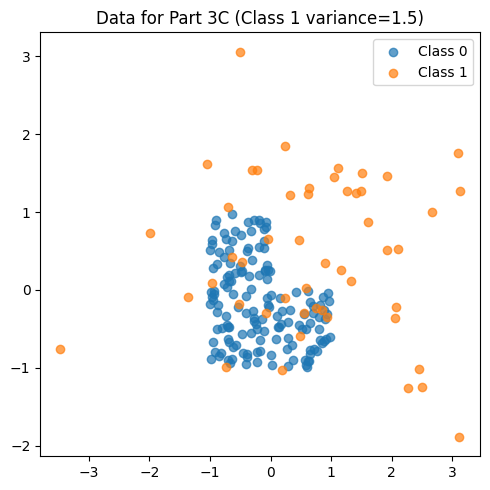

In [15]:
def generate_data_part3C(n_class0=150, n_class1=50, seed=42):
    """
    Same as part 0, but Class 1 has larger variance (1.5, 1.5)
    """
    np.random.seed(seed)

    n0_each = n_class0 // 3
    # Class 0
    x1 = np.random.uniform(-1.0, 0.0, (n0_each, 2))
    x2 = np.random.uniform([ -1.0,  0.0], [0.0, 1.0], (n0_each, 2))
    x3 = np.random.uniform([ 0.0, -1.0], [1.0,  0.0], (n0_each, 2))
    X0 = np.vstack((x1, x2, x3))

    mean = [0.5, 0.5]
    cov = [[1.5, 0.0], [0.0, 1.5]]
    X1 = np.random.multivariate_normal(mean, cov, n_class1)

    X = np.vstack((X0, X1))
    y = np.concatenate((np.zeros(len(X0)), np.ones(len(X1))))
    return X, y

# Generate data with bigger variance in Class 1
X3C, y3C = generate_data_part3C()
plot_data(X3C, y3C, title="Data for Part 3C (Class 1 variance=1.5)", save_path="part3C_data_plot.png")

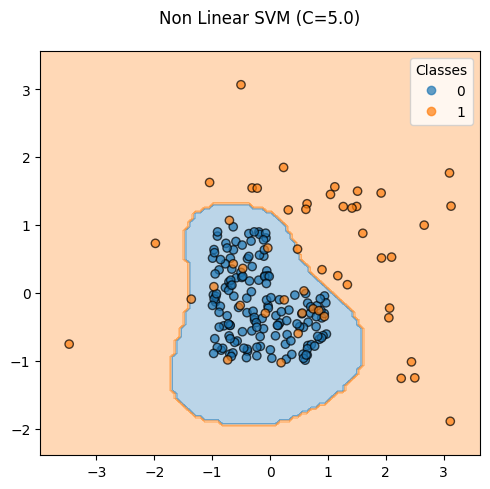



Nonlinear SVM (C=5.0) 4-fold CV Results

Per-Fold Metrics:
      Accuracy  Precision  Recall   AUROC
Fold                                     
1         0.96        1.0  0.8333  0.8882
2         0.92        1.0  0.6667  0.8750
3         0.86        1.0  0.4615  0.8254
4         0.92        1.0  0.6923  0.8108

Aggregated CV Metrics:
Mean Accuracy: 0.9150
Accuracy Variance: 0.0017
Mean AUROC: 0.8498

Test Set Results:
Test Accuracy     0.7755
Test Precision    1.0000
Test Recall       0.5600
Test AUROC        0.9117
dtype: float64


In [16]:
## Nonlinear SVM with C=5 for newly created data
agg_nlsvmC, fold_nlsvmC, test_nlsvmC = run_nonlinear_svm(
    X3C, y3C, X_test, y_test, C_value=5.0
)
print("\n\nNonlinear SVM (C=5.0) 4-fold CV Results\n" + "="*40)
print("\nPer-Fold Metrics:")
print(fold_nlsvmC.round(4).to_string())
print("\nAggregated CV Metrics:")
print(f"Mean Accuracy: {agg_nlsvmC['Mean Accuracy']:.4f}")
print(f"Accuracy Variance: {agg_nlsvmC['Accuracy Variance']:.4f}")
print(f"Mean AUROC: {agg_nlsvmC['Mean AUROC']:.4f}")

print("\nTest Set Results:")
print(pd.Series(test_nlsvmC).round(4))


Balanced regularization (C=5) achieves peak CV accuracy (91.5%) and robust test AUROC (0.912), but test recall drops (56%) due to increased Class 1 variance, highlighting the tradeoff between stability and minority-class sensitivity.

## Part 4: Mismatch between training and test data
For test data, use the same distribution of Class 0 as before, such as in Part 3C. Similar to Part 3C, set
the Class 1 variance to (1.5, 1.5).
For training data, change the Class 0 samples to be uniformly distributed in the (union of the) 3 squares
[-0.5, 0.5]x[-0.5, 0.5] + [-0.5, 0.5]x[0.5, 0.5] + [0, 1]x[-0.5, 0.5]. Class 1 is Gaussian distributed centered at
(0.5, 0.5) with variance (0.5, 0.5).
Implement a nonlinear SVM. Train using the training data. Use 4-fold cross validation and the test data to
report the accuracy, precision, recall, AUROC metrics. What is the variance of the accuracy across the 4
runs?

In [17]:
## Test data
X_test4, y_test4 = X3C, y3C

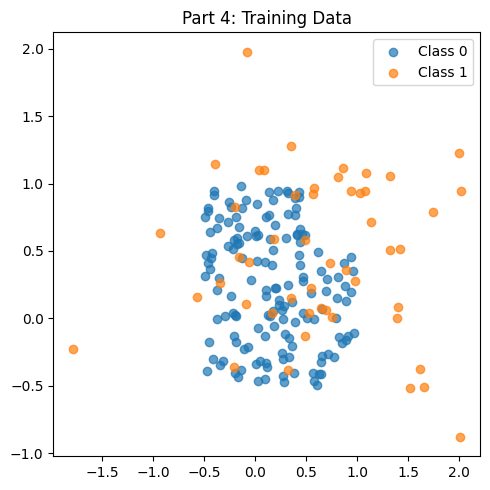

In [18]:
def generate_train_mismatch(n_class0=150, n_class1=50, seed=42):
    """
    For training data:
      - Class 0: uniform in some smaller squares that differ from Part 3C
      - Class 1: Gaussian( (0.5, 0.5), [[0.5, 0],[0,0.5]] )

    This differs from the test distribution, which can be from generate_data_part3C.
    """
    np.random.seed(seed)

    n0_each = n_class0 // 3
    # square1: [-0.5,0.5] x [-0.5,0.5]
    sq1 = np.random.uniform([-0.5, -0.5], [0.5, 0.5], (n0_each, 2))
    # square2: [-0.5,0.5] x [0.5,1.0]
    sq2 = np.random.uniform([-0.5, 0.5], [0.5, 1.0], (n0_each, 2))
    # square3: [0,1] x [-0.5,0.5]
    sq3 = np.random.uniform([0.0, -0.5], [1.0,  0.5], (n0_each, 2))

    X0 = np.vstack((sq1, sq2, sq3))

    mean = [0.5, 0.5]
    cov = [[0.5, 0.0], [0.0, 0.5]]
    X1 = np.random.multivariate_normal(mean, cov, n_class1)

    X = np.vstack((X0, X1))
    y = np.concatenate((np.zeros(len(X0)), np.ones(len(X1))))
    return X, y

# Generate training data (mismatch)
X_train_mismatch, y_train_mismatch = generate_train_mismatch()
plot_data(X_train_mismatch, y_train_mismatch, title="Part 4: Training Data",save_path="part4_data_plot.png")

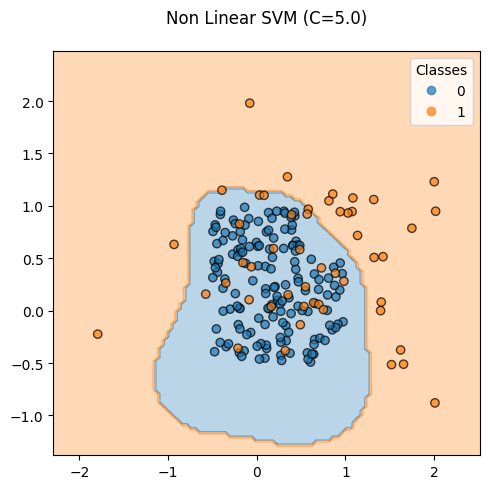



Nonlinear SVM (Mismatched Data) 4-fold CV Results

Per-Fold Metrics:
      Accuracy  Precision  Recall   AUROC
Fold                                     
1         0.88        1.0  0.5000  0.8596
2         0.86        1.0  0.4167  0.7807
3         0.82        1.0  0.3077  0.7006
4         0.86        1.0  0.4615  0.6819

Aggregated CV Metrics:
Mean Accuracy: 0.8550
Accuracy Variance: 0.0006
Mean AUROC: 0.7557

Test Set Results:
Test Accuracy:     0.8400
Test Precision:    0.6875
Test Recall:       0.6600
Test AUROC:        0.7832


In [19]:
def run_nonlinear_svm_mismatch(X_train, y_train, X_test, y_test, C_value=1.0):
    """
    Consistent with run_nonlinear_svm() from Part 3
    """
    svm = SVC(C=C_value, kernel='rbf', gamma='scale', random_state=42)


    # Cross-validation
    agg_metrics, fold_metrics = cross_validate_model(svm, X_train, y_train)
    # Train on full training data
    svm.fit(X_train, y_train)

    title = f"Non Linear SVM (C={C_value})"
    plot_decision_boundary(svm, X_train, y_train,
                          title=title,
                          save_path=f"part3_{C_value}_boundary.png")
    # Test set evaluation
    y_pred = svm.predict(X_test)
    y_score = svm.decision_function(X_test)
    test_metrics = {
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Test Precision": precision_score(y_test, y_pred, zero_division=0),
        "Test Recall": recall_score(y_test, y_pred, zero_division=0),
        "Test AUROC": roc_auc_score(y_test, y_score)
    }
    return agg_metrics, fold_metrics, test_metrics

# Run and print results
agg_mismatch, fold_mismatch, test_mismatch = run_nonlinear_svm_mismatch(
    X_train_mismatch, y_train_mismatch,
    X_test4, y_test4,
    C_value=5.0  # Reasonable C as per Part 3C
)

# Print formatted results (identical to your previous structure)
print("\n\nNonlinear SVM (Mismatched Data) 4-fold CV Results\n" + "="*40)
print("\nPer-Fold Metrics:")
print(fold_mismatch.round(4).to_string())
print("\nAggregated CV Metrics:")
print(f"Mean Accuracy: {agg_mismatch['Mean Accuracy']:.4f}")
print(f"Accuracy Variance: {agg_mismatch['Accuracy Variance']:.4f}")
print(f"Mean AUROC: {agg_mismatch['Mean AUROC']:.4f}")
print("\nTest Set Results:")
print(f"Test Accuracy:     {test_mismatch['Test Accuracy']:.4f}")
print(f"Test Precision:    {test_mismatch['Test Precision']:.4f}")
print(f"Test Recall:       {test_mismatch['Test Recall']:.4f}")
print(f"Test AUROC:        {test_mismatch['Test AUROC']:.4f}")


In Cross-Validation shows low AUROC (0.756) suggests poor class separability during training, despite reasonable accuracy (85.5%), highlighting the impact of mismatched data.
In Test set the AUROC is comparably low (0.783), confirming persistent challenges in distinguishing classes.
Moreover, despite using a large `C=5` (low regularization), the model fails to generalize robustly.  

## Part 5: High Variance

Generate the data sets as in Part 3C (i.e., no mismatch between training and test data sets). Reduce the
number of samples in the training set to 60 samples in Class 0 and 20 samples in Class 1. Implement a
nonlinear SVM. Train using the training data. Use 4-fold cross validation and the test data to report the
accuracy, precision, recall, AUROC metrics. What is the variance of the accuracy across the 4 runs?

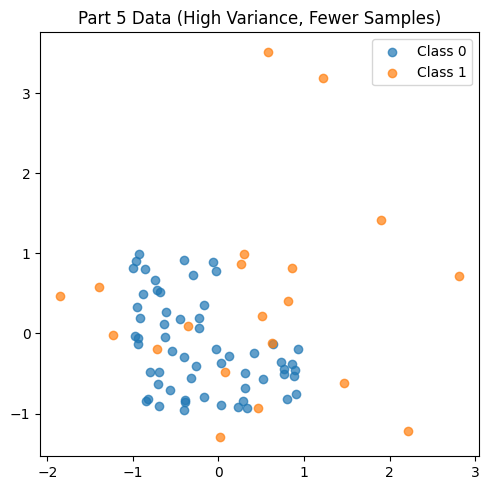

In [20]:
X5, y5 = generate_data_part3C(n_class0=60, n_class1=20, seed=42)
plot_data(X5, y5, title="Part 5 Data (High Variance, Fewer Samples)", save_path="part5_data_plot.png")

# # We'll do a nonlinear SVM (RBF) again, 4-fold CV
# results_part5 = run_svm_cv(X5, y5, kernel="rbf", C=10.0)
# print("Part 5 (RBF SVM, C=10.0) 4-fold CV results:")
# print(results_part5)

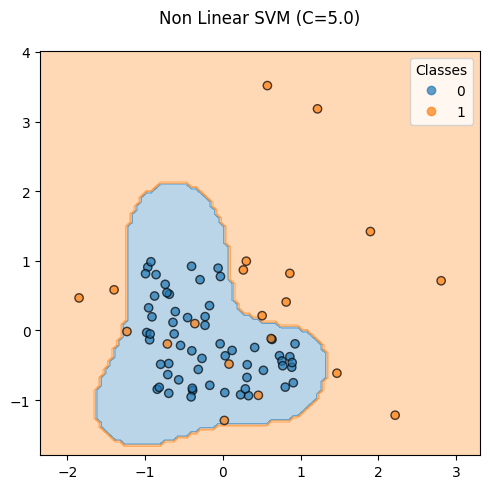



Nonlinear SVM (Reduced Samples) 4-fold CV Results

Per-Fold Metrics:
      Accuracy  Precision  Recall   AUROC
Fold                                     
1         0.85        1.0     0.4  0.7733
2         0.90        1.0     0.6  0.6667
3         0.90        1.0     0.6  0.9067
4         0.90        1.0     0.6  0.9600

Aggregated CV Metrics:
Mean Accuracy: 0.8875
Accuracy Variance: 0.0006
Mean AUROC: 0.8267

Test Set Results:
Test Accuracy:     0.7959
Test Precision:    1.0000
Test Recall:       0.6000
Test AUROC:        0.9254


In [22]:
# PART 5: REDUCED TRAINING DATA (NONLINEAR SVM)
def run_nonlinear_svm_reduced(X_train, y_train, X_test, y_test, C_value=1.0):

    svm = SVC(C=C_value, kernel='rbf', gamma='scale', random_state=42)
    agg_metrics, fold_metrics = cross_validate_model(svm, X_train, y_train)
    svm.fit(X_train, y_train)
    title = f"Non Linear SVM (C={C_value})"
    plot_decision_boundary(svm, X_train, y_train,
                          title=title,
                          save_path=f"part5_{C_value}_boundary.png")
    y_pred = svm.predict(X_test)
    y_score = svm.decision_function(X_test)
    test_metrics = {
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Test Precision": precision_score(y_test, y_pred, zero_division=0),
        "Test Recall": recall_score(y_test, y_pred, zero_division=0),
        "Test AUROC": roc_auc_score(y_test, y_score)
    }
    return agg_metrics, fold_metrics, test_metrics

agg_part5, fold_part5, test_part5 = run_nonlinear_svm_reduced(
    X5, y5, X_test, y_test, C_value=5.0
)

# Print results (identical to Part 3/4 formatting)
print("\n\nNonlinear SVM (Reduced Samples) 4-fold CV Results\n" + "="*40)
print("\nPer-Fold Metrics:")
print(fold_part5.round(4).to_string())
print("\nAggregated CV Metrics:")
print(f"Mean Accuracy: {agg_part5['Mean Accuracy']:.4f}")
print(f"Accuracy Variance: {agg_part5['Accuracy Variance']:.4f}")
print(f"Mean AUROC: {agg_part5['Mean AUROC']:.4f}")
print("\nTest Set Results:")
print(f"Test Accuracy:     {test_part5['Test Accuracy']:.4f}")
print(f"Test Precision:    {test_part5['Test Precision']:.4f}")
print(f"Test Recall:       {test_part5['Test Recall']:.4f}")
print(f"Test AUROC:        {test_part5['Test AUROC']:.4f}")

Reduced samples amplify class imbalance challenges, but the model maintains stability (low Cross Validation accuracy variance: 0.0006)